## 4. 3번의 상권별 특성 파악
* 업종별 특성 파악
* 매출, 성별, 연령대 집중도 등

4에서 사용되는 테이블
* 유동인구 많은 상위 지역(resident_area, working_area)별로 업종 파악: service_Category
* 유동인구 많은 상위 지역의 매출, 성별, 연령대 집중도: Sales_Sex, Sales_Age, Floating_Population

## 4.1. 업종별 특성 파악

### DB에서 데이터 가져오기

In [32]:
import mysql.connector
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

remote = mysql.connector.connect(
    host = os.getenv("DB_HOST"),
    user = os.getenv("DB_USER"),
    password = os.getenv("DB_PASSWORD"),
    database = "triodb"
)

query = """
-- 상권별 상주+직장 인구 합계
WITH pop_summary AS (
    SELECT
        year_quarter,
        commercial_area_code,
        SUM(population) AS total_population,
        pop_type
    FROM Population_GA
    GROUP BY year_quarter, commercial_area_code, pop_type
)
SELECT
    ca.name,
    sc.commercial_area_code,
    ps.pop_type,
    sc.service_category_code,
    sca.name "service_category_name",
    sc.shop_count,
    sc.similar_shop_count,
    ps.total_population
FROM Shop_Count sc
JOIN pop_summary ps
    ON sc.year_quarter = ps.year_quarter
    AND sc.commercial_area_code = ps.commercial_area_code
JOIN Commercial_Area ca
    ON ca.code = sc.commercial_area_code
JOIN Service_Category sca
    ON sca.code = sc.service_category_code;
"""

df = pd.read_sql(query, remote)

remote.close()

df.tail()

/var/folders/x1/3x1wk6hx6g3_dv91vx02k_dm0000gn/T/ipykernel_27962/2317859657.py:46: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, remote)


,name,commercial_area_code,pop_type,service_category_code,service_category_name,shop_count,similar_shop_count,total_population
611057,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300024,운동/경기용품,5,5,894.0
611058,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300027,섬유제품,2,2,894.0
611059,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300029,애완동물,1,1,894.0
611060,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300035,인테리어,2,2,894.0
611061,"평화시장(남평화시장, 제일평화시장, 신평화패션타운)",3130327,WORKING,CS300043,전자상거래업,4,4,894.0


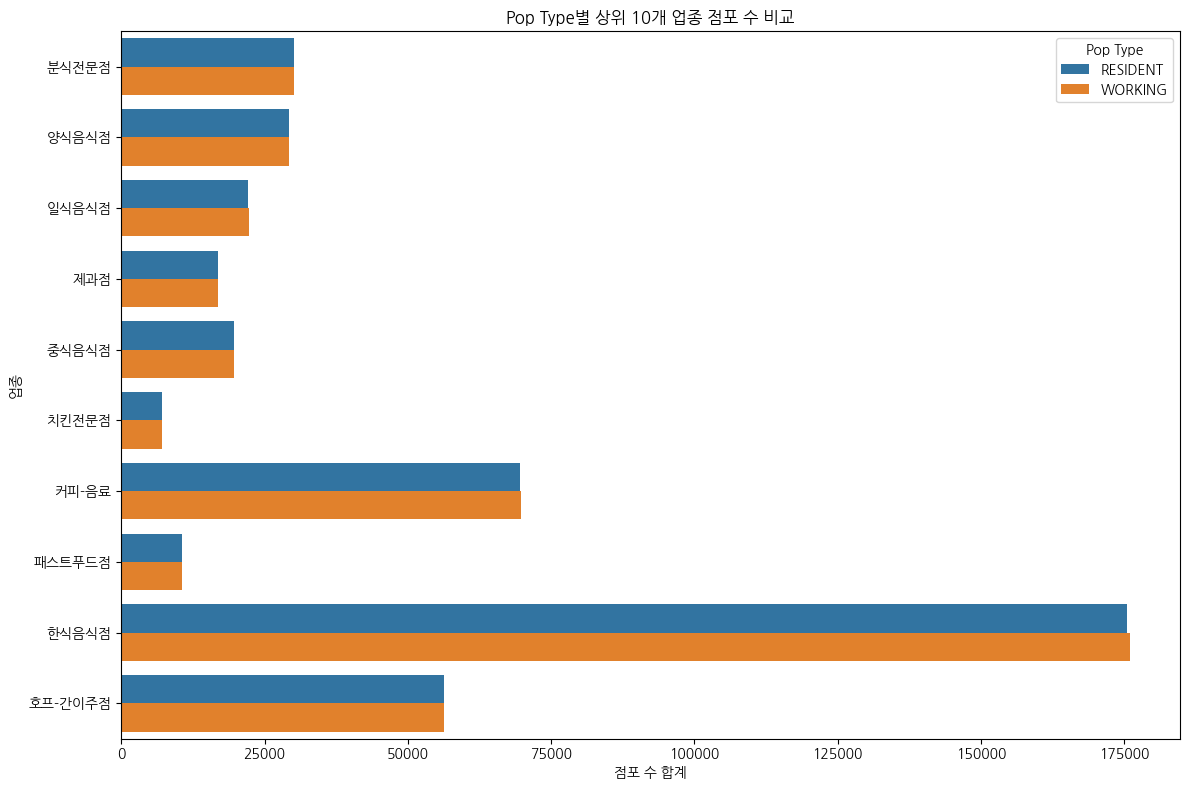

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 분석에 사용할 업종 리스트
categories = [
    '한식음식점', '중식음식점', '일식음식점', '양식음식점',
    '제과점', '패스트푸드점', '치킨전문점', '분식전문점',
    '호프-간이주점', '커피-음료'
]

# top10 업종 필터링
df_filtered = df[df['service_category_name'].isin(categories)]

# pop_type별 업종별 점포 수 합계
agg_df = df_filtered.groupby(['pop_type', 'service_category_name']).agg(
    total_shop_count=('shop_count', 'sum')
).reset_index()

# pop_type별 색상
palette = {'RESIDENT':'#1f77b4', 'WORKING':'#ff7f0e'}

plt.figure(figsize=(12, 8))
sns.barplot(
    data=agg_df,
    x='total_shop_count',
    y='service_category_name',
    hue='pop_type',
    palette=palette
)
plt.title('Pop Type별 상위 10개 업종 점포 수 비교')
plt.xlabel('점포 수 합계')
plt.ylabel('업종')
plt.legend(title='Pop Type')
plt.tight_layout()
plt.show()

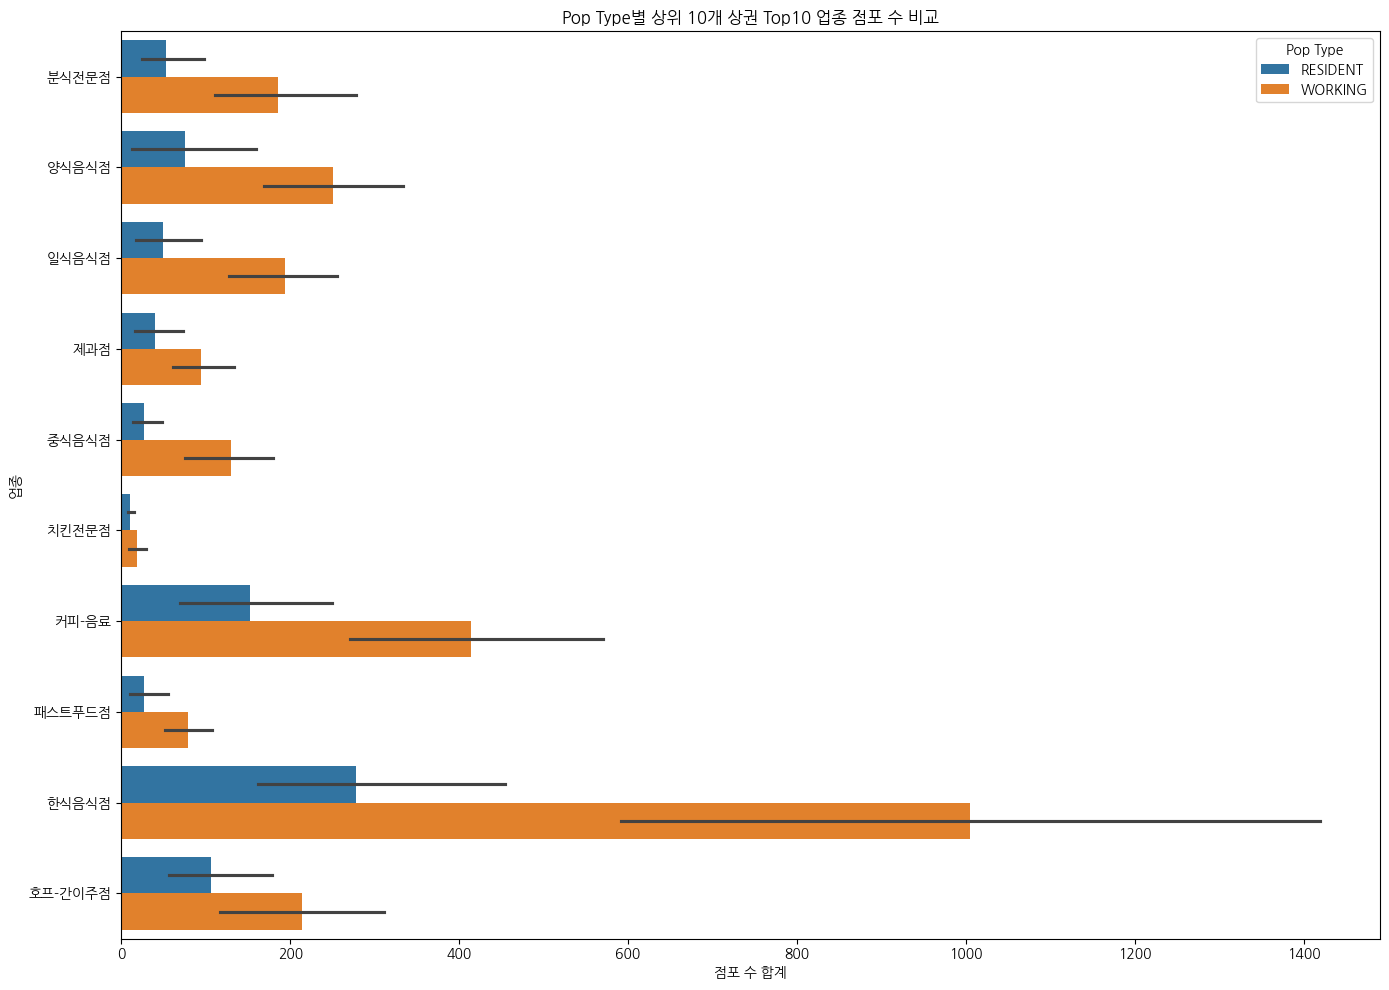

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 상위 10개 상권 리스트
resident_top10 = [
    '화곡역 4번','까치산역 4번','망리단길','까치산역 1번','관악구 중앙길',
    '신림역 5번(신림동주민센터, 신림동별빛거리)','잠실 관광특구','선유도역 1번',
    '응암역 3번','길동주민센터(강동도서관)'
]
working_top10 = [
    '명동 남대문 북창동 다동 무교동 관광특구','여의도역(여의도)','잠실 관광특구',
    '삼성역','강남 마이스 관광특구','가산디지털단지','매봉역','잠실역','포스코사거리','강남역'
]

# top10 업종
categories = [
    '한식음식점', '중식음식점', '일식음식점', '양식음식점',
    '제과점', '패스트푸드점', '치킨전문점', '분식전문점',
    '호프-간이주점', '커피-음료'
]

# 상위 상권 & top10 업종 필터링
df_filtered = df[
    ((df['pop_type']=='RESIDENT') & (df['name'].isin(resident_top10)) |
     (df['pop_type']=='WORKING') & (df['name'].isin(working_top10)))
    & df['service_category_name'].isin(categories)
]

# 업종별 점포 수 합계
agg_df = df_filtered.groupby(['pop_type','name','service_category_name']).agg(
    total_shop_count=('shop_count','sum')
).reset_index()

# 색상 설정
palette = {'RESIDENT':'#1f77b4', 'WORKING':'#ff7f0e'}

# 시각화
plt.figure(figsize=(14, 10))
sns.barplot(
    data=agg_df,
    x='total_shop_count',
    y='service_category_name',
    hue='pop_type',
    palette=palette
)
plt.title('Pop Type별 상위 10개 상권 Top10 업종 점포 수 비교')
plt.xlabel('점포 수 합계')
plt.ylabel('업종')
plt.legend(title='Pop Type')
plt.tight_layout()
plt.show()

### 결론
인구별(상주인구/직장인구) 매출 탑10 매장들은 한식 음식점이 많았다
유동인구는 데이터 매핑을 해도 유의미한 결과가 안 나와서 (숫자 그대로가 아니라 지수를 이용해야 함) 건너뜀

## 4.2. 매출/연령/성별 파악

In [25]:
import mysql.connector
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

load_dotenv()

remote = mysql.connector.connect(
    host = os.getenv("DB_HOST"),
    user = os.getenv("DB_USER"),
    password = os.getenv("DB_PASSWORD"),
    database = "triodb"
)

query = """
SELECT 
    ts.store_id,
    ts.commercial_area_name,
    ts.service_category_code,
    ts.total_sales,
    
    sex.sex AS gender,
    sex.sales AS sales_by_gender,
    
    age.age AS age_band,
    age.sales AS sales_by_age,
    
    sd.week AS week_day,
    sd.sales AS sales_by_weekday,
    
    st.time AS time_slot,
    st.sales AS sales_by_time

FROM
(
    SELECT 
        sc.id AS store_id,
        ca.name AS commercial_area_name,
        sc.service_category_code,
        SUM(st.sales) AS total_sales
    FROM Shop_Count sc
    JOIN Sales_Time st ON sc.id = st.store_id
    JOIN Commercial_Area ca ON sc.commercial_area_code = ca.code
    GROUP BY sc.id, ca.name, sc.service_category_code
    ORDER BY total_sales DESC
    LIMIT 20
) ts
LEFT JOIN Sales_Sex sex ON ts.store_id = sex.store_id
LEFT JOIN Sales_Age age ON ts.store_id = age.store_id
LEFT JOIN Sales_Day sd ON ts.store_id = sd.store_id
LEFT JOIN Sales_Time st ON ts.store_id = st.store_id
ORDER BY ts.total_sales DESC, ts.store_id;
"""

df = pd.read_sql(query, remote)

remote.close()

df.head()

/var/folders/x1/3x1wk6hx6g3_dv91vx02k_dm0000gn/T/ipykernel_27962/1473939832.py:56: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, remote)


,store_id,commercial_area_name,service_category_code,total_sales,gender,sales_by_gender,age_band,sales_by_age,week_day,sales_by_weekday,time_slot,sales_by_time
0,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,00-06,30297569176
1,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,06-11,195120243141
2,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,11-14,256704315137
3,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,14-17,275154245000
4,58410,노량진역(노량진),CS300008,1.144904e+12,MALE,630887504593,TEENS,419938227,MONDAY,118324535344,17-21,365472334060


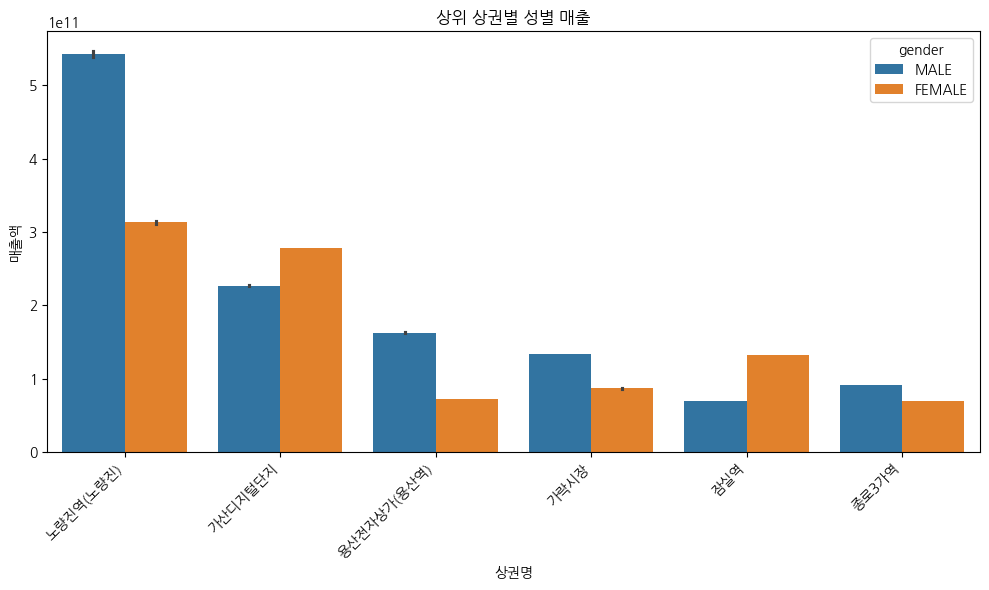

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib

# 1. 성별 매출 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='commercial_area_name', y='sales_by_gender', hue='gender')
plt.title('상위 상권별 성별 매출')
plt.xticks(rotation=45, ha='right')
plt.ylabel('매출액')
plt.xlabel('상권명')
plt.tight_layout()
plt.show()


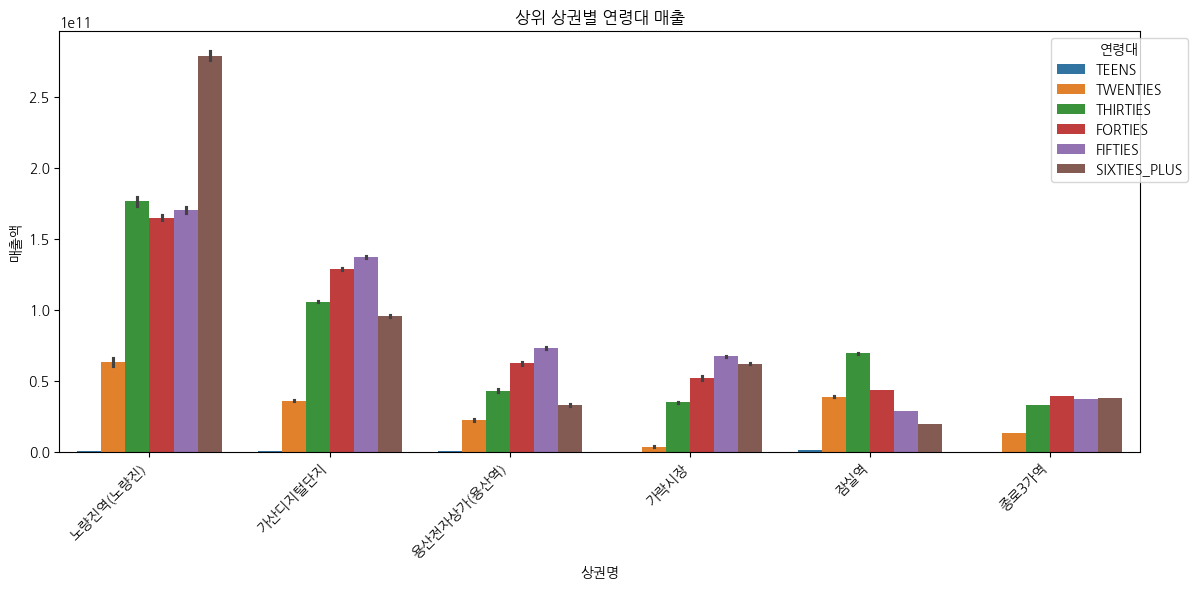

In [29]:
# 2. 연령대 매출 시각화
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='commercial_area_name', y='sales_by_age', hue='age_band')
plt.title('상위 상권별 연령대 매출')
plt.xticks(rotation=45, ha='right')
plt.ylabel('매출액')
plt.xlabel('상권명')
plt.legend(title='연령대', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


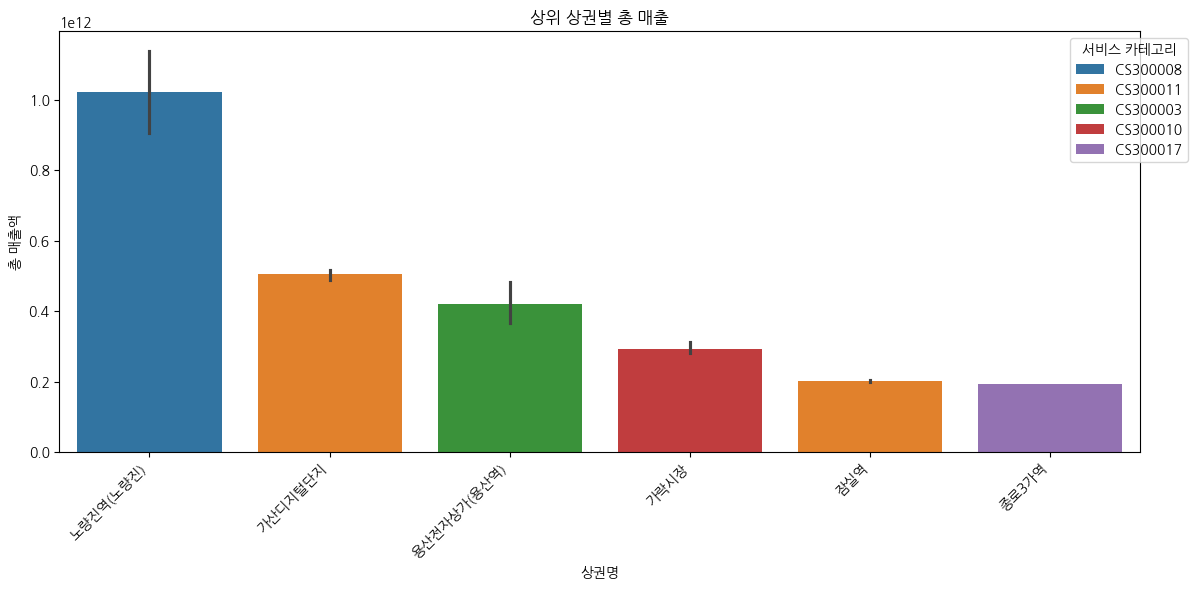

In [30]:
# 3. 점포별 총 매출 비교 (서비스 카테고리 포함)
plt.figure(figsize=(12, 6))
sns.barplot(data=df.drop_duplicates('store_id'), 
            x='commercial_area_name', y='total_sales', hue='service_category_code')
plt.title('상위 상권별 총 매출')
plt.xticks(rotation=45, ha='right')
plt.ylabel('총 매출액')
plt.xlabel('상권명')
plt.legend(title='서비스 카테고리', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()